In [62]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

# only run if first-time setup
# Fetching all session, insertion, and spike data
# DAVIDE: for some reason, fetching keeps getting interrupted by the absence of certain files/directories.
#%run -i fetchdata.py -a

# Load session and insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

# dropping na (PCA_DC)
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

# Create a DataFrame with eids (all sessions with a left vid), categorized by experimental group
eids_exp = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == False), 'eid']
eids_cont = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == True), 'eid']

#------------------------ Functions-------------------------
import os
import numpy as np
import pandas as pd

def download_video(eid, camera = "left"):
    """
    Downloads raw video data from specific session. Camera parameter can be switched to "body" and "right".
    
    Parameters
    ----------
    eid (str): Experiment/session identifier

    camera (str): Camera orientation identifier (left by default). "body", "right" are other available options.

    Returns
    -------
    video_path: Local path for saved video
    """
    
    if camera == "left":
        video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')
    elif camera == "right":
        video_path = one.load_dataset(eid, f'*rightCamera.raw*', collection='raw_video_data')
    elif camera == "body":
        video_path = one.load_dataset(eid, f'*bodyCamera.raw*', collection='raw_video_data')
    else:
         raise ValueError(f"Unknown camera parameter: {camera}")

    return video_path

def get_time_epochs(df_sessions, eid):

    video_data = df_sessions.loc[df_sessions['eid'] == eid]
    
    # epochs
    epoch_pre = [
        ("task00_spontaneous", video_data['task00_spontaneous_start'].values[0], video_data['task00_spontaneous_stop'].values[0]),
        ("task00_rfm", video_data['task00_rfm_start'].values[0], video_data['task00_rfm_stop'].values[0]),
        ("task00_replay", video_data['task00_replay_start'].values[0], video_data['task00_replay_stop'].values[0])
    ]

    epoch_post = [
        ("task01_spontaneous", video_data['task01_spontaneous_start'].values[0], video_data['task01_spontaneous_stop'].values[0]),
        ("task01_rfm", video_data['task01_rfm_start'].values[0], video_data['task01_rfm_stop'].values[0]),
        ("task01_replay", video_data['task01_replay_start'].values[0], video_data['task01_replay_stop'].values[0])
    ]

    return epoch_pre, epoch_post


# will be useful for multi-video analysis at the end
def load_pca_results(results, eid, epoch_name):
    """
    Imports MotionMap results on motion energy video analysis. Obtains path for .npy file based on eid, loads, and returns the data
    in a dataframe. a

    Parameters
    ----------
    results: pd.DataFrame
        Dataframe containing PCA results containing eid, epoch_name, savename
    eid: str
        Experiment/session identifier.
    epoch_name: str
        Epoch identifier. Can take the values of 'spontaneous','rfm', or 'replay'

    Returns
    -------
    pre, post = pd. Dataframe
        MotionMap results for pre/post particular epochs.
    """
        

    path_df = results[results['eid'] == eid]

    if epoch_name == 'spontaneous':
        pre = np.load(path_df[path_df['epoch'] == 'pre_spo']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_spo']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'rfm':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rfm']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rfm']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'replay':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rep']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rep']['savename'].values[0], allow_pickle=True).item()

    else:
        raise NameError(f"Epoch name not recognized {epoch_name}")
    return pre, post


In [63]:
# Import dataframe with PCA results entries (eid, epoch_name, filepath)
exp_results = pd.read_csv(r'C:\Users\marti\Documents\mainen\psychedelics\video\exp_results')

# Correct the epoch_name for easier access (otherwise interval stamps mess up possible grouping)
# Assumes consecutive loading (each eid, 6 sorted epochs)
epoch_naming = ['pre_spo', 'pre_rfm', 'pre_rep', 'post_spo', 'post_rfm', 'post_rep']

for eid, group in exp_results.groupby('eid'):
    idx = group.index
    if len(idx) == len(epoch_naming):
        exp_results.loc[idx, 'epoch'] = epoch_naming
    else:
        print(f"Warning: eid {eid} has {len(idx)} entries, expected {len(epoch_naming)}")

pre, post = load_pca_results(exp_results, '58ca39c5-e27f-43c4-8516-2ccc4fe88042', 'replay')

In [174]:
# Temporal masks: full video, frame-level SVD (frame x component)
def get_eigen(epoch_result, reshaped = False):

    frame_masks = epoch_result['motSVD']
    frame_masks = np.stack(frame_masks[0], axis = 0) 
    print("Temporal PC matrix has shape", frame_masks.shape)
    # Eigenfaces: each 
    eigenmsk = epoch_result['motMask'] # binned pixels x components
    eigenmsk=np.stack(eigenmsk[0], axis = 0)
    print("Eigenmask matrix has shape ", eigenmsk.shape)

    # Reshaped eigenfaces
    re_eigenmsk = epoch_result['motMask_reshape'] # reshaped by bins (x, y, components)
    re_eigenmsk=np.stack(re_eigenmsk[0], axis = 0)

    # Eigenvalues: they are in order (sanity check)
    eigenval = epoch_result['motSv']
    print("Eigenvalues array has shape ", eigenval.shape)
    if reshaped:
        return re_eigenmsk, frame_masks, eigenval
    else:
        return eigenmsk, frame_masks, eigenval

In [175]:
eidx = exp_results['eid'].unique()[0]

#replay
pre, post = load_pca_results(exp_results, eidx, epoch_name='replay')

pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
post_eigenmsk, _, post_eigenval = get_eigen(post)

Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
Eigenvalues array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
Eigenvalues array has shape  (500,)


In [ ]:
pre_eigenval


array([40382.59  , 22491.467 , 19329.514 , 16734.252 , 14812.699 ,
       14252.607 , 11458.69  , 11096.604 , 10596.38  , 10039.705 ,
        9459.06  ,  9215.396 ,  8874.794 ,  8664.475 ,  8289.558 ,
        8200.126 ,  8088.9062,  7874.589 ,  7564.382 ,  7181.352 ,
        7066.354 ,  7040.934 ,  6923.617 ,  6739.495 ,  6660.3223,
        6496.3613,  6416.506 ,  6224.267 ,  6179.7207,  6026.7188,
        5940.909 ,  5898.8594,  5725.71  ,  5650.0576,  5481.7627,
        5427.011 ,  5393.123 ,  5365.454 ,  5294.6733,  5199.586 ,
        5102.6553,  5069.9287,  5047.2827,  4992.338 ,  4966.043 ,
        4896.199 ,  4859.9673,  4819.163 ,  4780.1943,  4752.2607,
        4736.6616,  4639.9385,  4596.6313,  4567.5933,  4537.3916,
        4517.1494,  4494.8125,  4443.0947,  4407.5464,  4381.547 ,
        4332.2104,  4302.93  ,  4297.053 ,  4254.275 ,  4226.802 ,
        4208.3115,  4179.6997,  4142.2407,  4118.283 ,  4105.4463,
        4091.2861,  4060.8098,  4040.3071,  3997.1287,  3988.5

In [168]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util
k = 500 #<-- components to keep
similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)

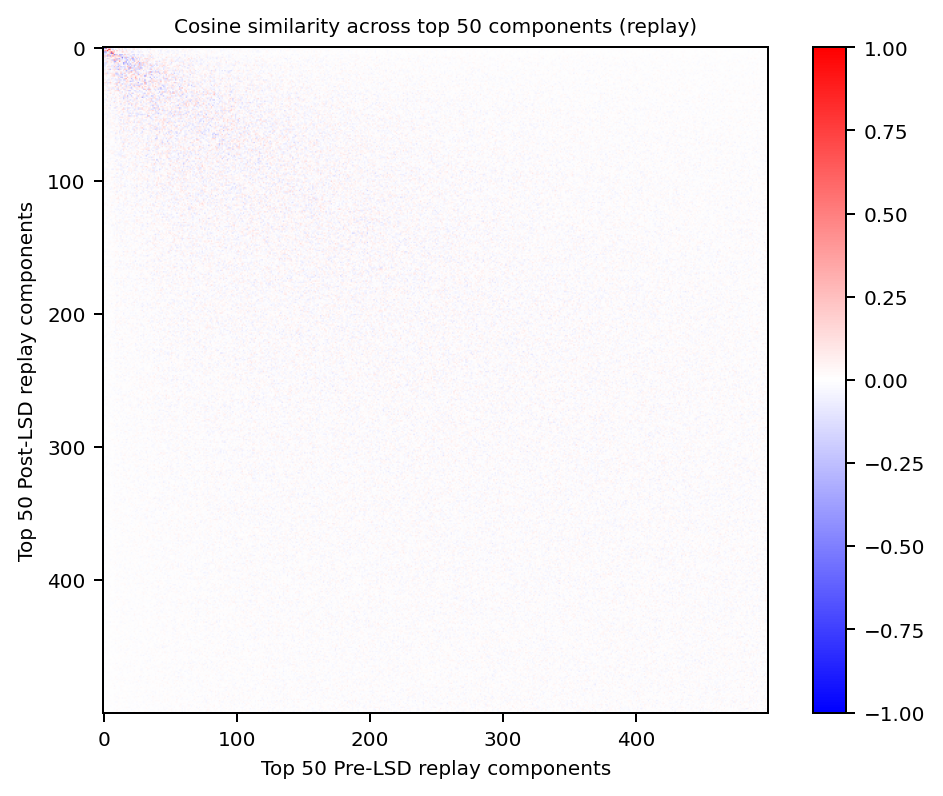

In [169]:
fig, ax0 = plt.subplots()
cax = ax0.imshow(similarity_matrix, cmap='bwr', vmin=-1, vmax=1)
ax0.set_title("Cosine similarity across top 50 components (replay)")
ax0.set_xlabel("Top 50 Pre-LSD replay components")
ax0.set_ylabel("Top 50 Post-LSD replay components")
fig.colorbar(cax, ax=ax0)
plt.show()

significant analysis here depends on how these "change" metrics compare to the control case. That way, I could claim some sort of significant behavioral change upon LSD administration

possible next steps:
- subplane similarity analysis. take top k (argmax) components from individual pair cos analysis and compare the basis. This could give a more nuanced comparison in behavioral change, but I'm afraid the angle intuition necessarily get lost.
- the fact that it's two different motif basis is getting on my nerves. Lempel-ziv
